In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np
import talib
from ta.trend import EMAIndicator
import matplotlib.pyplot as plt
import ta
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv, find_dotenv

In [11]:
load_dotenv()

True

In [12]:
ticker = ["SPY"]
# Set timeframe to "1Day" for Alpaca API
timeframe = "1day"
# Format current date as ISO format
start_date = pd.Timestamp("2019-01-06", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-01-28", tz="America/New_York").isoformat()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)


stock_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
# Drop unwanted coloumns - Keep  Close
#stock_data.drop(columns= ['trade_count','vwap','symbol'], inplace= True)
    # Combine individual stocks into a single data frame

  # Rename the coloumns to the ticker symbols in the list
#stock_data.columns = ticker
stock_data.index.name = 'Date'
stock_data.index_column = 'Date'
# Drop the N/As


# Drop the time component of the date
#df_ticker.index = df_ticker.index.date


# Display the data
display(stock_data)

,open,high,low,close,volume,trade_count,vwap,symbol
Date,,,,,,,,
2019-01-07 05:00:00+00:00,252.700,255.9500,251.69,254.29,103705813,449998,254.069565,SPY
2019-01-08 05:00:00+00:00,256.820,257.3100,254.00,256.62,103267687,461977,255.845300,SPY
2019-01-09 05:00:00+00:00,257.560,258.9100,256.19,257.92,95741225,438058,257.817252,SPY
2019-01-10 05:00:00+00:00,256.260,259.1600,255.50,258.98,98012473,417182,257.827540,SPY
2019-01-11 05:00:00+00:00,257.680,259.0098,257.03,258.81,74684741,298075,258.331868,SPY
...,...,...,...,...,...,...,...,...
2023-01-23 05:00:00+00:00,396.720,402.6450,395.72,400.63,84187957,568843,399.770552,SPY
2023-01-24 05:00:00+00:00,398.880,401.1500,397.64,400.20,59549719,434698,399.936054,SPY
2023-01-25 05:00:00+00:00,395.950,400.7000,393.56,400.35,84826825,583807,397.858257,SPY


In [13]:
def trade_strategy(stock_data, model, X_test):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Use predictions to create a strategy
    strategy = pd.DataFrame({'Prediction': y_pred}, index=stock_data.index[-len(y_pred):])
    strategy['Order'] = 0
    strategy.loc[strategy['Prediction'] > stock_data['close'][-len(y_pred):], 'Order'] = 1
    strategy.loc[strategy['Prediction'] < stock_data['close'][-len(y_pred):], 'Order'] = -1
    
    return strategy

In [14]:
# Create feature set and target
X = stock_data[['open', 'high', 'low', 'volume']]
y = stock_data['close']

In [15]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Define regression models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(random_state=42)
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
svr = SVR()

In [17]:
# Create stack
stack = StackingRegressor(estimators=[('RF', rf), ('GB', gb), ('Lasso', lasso), ('Ridge', ridge), ('SVR', svr)],
                          final_estimator=rf, cv=5)


In [18]:
# Fit stack
stack.fit(X_train, y_train)


C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+03, tolerance: 3.201e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.937e+02, tolerance: 2.571e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.323e+02, toleranc

StackingRegressor(cv=5,
                  estimators=[('RF', RandomForestRegressor(random_state=42)),
                              ('GB',
                               GradientBoostingRegressor(random_state=42)),
                              ('Lasso', Lasso(random_state=42)),
                              ('Ridge', Ridge(random_state=42)),
                              ('SVR', SVR())],
                  final_estimator=RandomForestRegressor(random_state=42))

In [19]:
# Get cross-validation score
cv_scores = cross_val_score(stack, X_train, y_train, cv=5)


C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.937e+02, tolerance: 2.571e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.408e+02, tolerance: 2.092e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dymde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.491e+02, toleranc

In [20]:
# Print scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean Cross-Validation Score: ", np.mean(cv_scores))


Cross-Validation Scores:  [0.99862597 0.99894733 0.99903202 0.99868164 0.99905468]
Mean Cross-Validation Score:  0.9988683274299139


In [21]:
# Use the stack to make predictions
strategy = trade_strategy(stock_data, stack, X_test)
print("Strategy: ", strategy)

Strategy:                             Prediction  Order
Date                                        
2022-04-05 04:00:00+00:00  388.191300     -1
2022-04-06 04:00:00+00:00  322.577900     -1
2022-04-07 04:00:00+00:00  347.206900     -1
2022-04-08 04:00:00+00:00  277.651600     -1
2022-04-11 04:00:00+00:00  418.193200     -1
...                               ...    ...
2023-01-23 05:00:00+00:00  383.808400     -1
2023-01-24 05:00:00+00:00  415.716600      1
2023-01-25 05:00:00+00:00  389.730600     -1
2023-01-26 05:00:00+00:00  279.050805     -1
2023-01-27 05:00:00+00:00  452.259100      1

[205 rows x 2 columns]


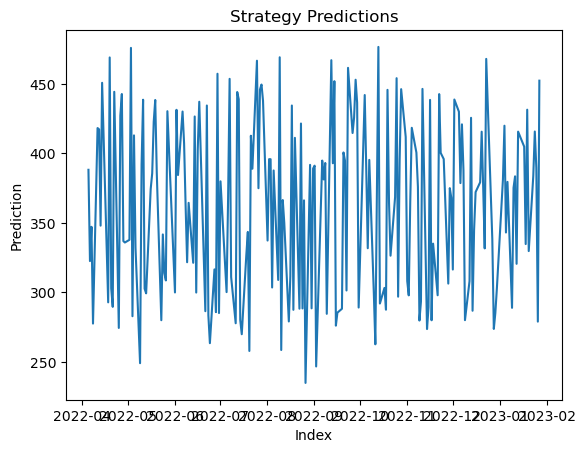

In [23]:

plt.plot(strategy.index, strategy['Prediction'])
plt.xlabel('Index')
plt.ylabel('Prediction')
plt.title('Strategy Predictions')
plt.show()